# Business Problem

## A) Business Situation

(Kaggle description) Instead of waking to overlooked "Do not disturb" signs, Airbnb travelers find themselves rising with the birds min a whimsical treehouse, having their morning coffee on the deck of a houseboat, or cooking a shared regional breakfast with their hosts. New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

    -- Business Problem (open question): What's the target destination for the 1st booking of new users?

## B) Business Understanding

    -- Which business model Airbnb operates? 
        -- Marketplace - conect people which offer acomodation to people searching for it)
            -- Supply (people offering accomodation)
                -- Portfolio size
                -- Portfolio density
                -- Average price
                
            -- Demand (people seeking accomodation)
                -- Users quantity
                -- LTV (Lifetime value)
                -- CAC (customer acquisition cost)
            -- Gross Revenue = (Fee * Customer Qty) - CAC 
    
    -- Objective: 
        -- Predict the destination choice for new users (1st booking)
        -- Motivation: Antecipate new users choice in order to offer most assertive ads
        -- Root Cause: Increase gross revenue (through cheaper CAC)
        -- Scope (Closed afirmation)
        -- Stakeholder: CFO/CEO

#### Solution Planning

Solution Overview:
Kind problem: City destination prediction
Potential methods: Classification
Output: 
Steps:
Inputs:
    -- Solution proposal:
        -- Machine Learning model in order to predict 1st AirBnB destination
        -- API:
            -- Input: user + characteristics
            -- Output: user + characteristics + destination prediction



    -- C) Insights
    -- D) Business Results
    -- E) Conclusions (Objectives attained? Problem Solved?)
    -- F) Next Steps
    -- G) Lessons Learned


### Data Fields

Is given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

File descriptions
train_users.csv - the training set of users

test_users.csv - the test set of users

    -- id: user id
    -- date_account_created: the date of account creation
    --- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
    -- date_first_booking: date of first booking
    -- gender
    -- age
    -- signup_method
    -- signup_flow: the page a user came to signup up from
    -- language: international language preference
    -- affiliate_channel: what kind of paid marketing
    -- affiliate_provider: where the marketing is e.g. google, craigslist, other
    -- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    -- signup_app
    -- first_device_type
    -- first_browser
    -- country_destination: this is the target variable you are to predict

sessions.csv - web sessions log for users
    -- user_id: to be joined with the column 'id' in users table
    -- action
    -- action_type
    -- action_detail
    -- device_type
    -- secs_elapsed

countries.csv - summary statistics of destination countries in this dataset and their locations

age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination

sample_submission.csv - correct format for submitting your predictions

# 0. Imports

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import accuracy_score,balanced_accuracy_score, cohen_kappa_score, classification_report, ConfusionMatrixDisplay

from keras import models as ml
from keras import layers as l

### 0.1 Helper Functions

In [67]:
def outlier_detection(data, column):
    
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    
    iqr = q3 - q1

    lo_lim = q1 - 1.5*iqr
    up_lim = q3 + 1.5*iqr
    
    outliers = [x for x in data[column] if (x > up_lim) | (x<lo_lim)]
    
    return sorted(outliers)

### 0.2 Loading Data

In [32]:
# in this case, we will proceed with 2 separated datasets and deal with issues then we will decide the granularity to merge
df_raw = pd.read_csv('dataset/train_users.csv')
df_raw.shape
print('The train_users dataset contains {} columns and {} rows'.format(df_raw.shape[1], df_raw.shape[0]))

The train_users dataset contains 16 columns and 213451 rows


In [33]:
df_sessions = pd.read_csv('dataset/sessions.csv')
df_sessions.shape
print('The sessions dataset contains {} columns and {} rows'.format(df_sessions.shape[1], df_sessions.shape[0]))

The sessions dataset contains 6 columns and 10567737 rows


# 1. Data Description

In [34]:
df1 = df_raw.copy()

## 1.1 NAs Check 

In [35]:
#users dataset
df1.isna().sum() / df1.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [86]:
#sessions dataset
df_sessions.isna().sum()/df_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

### 1.1.1 Dealing NAs

In [38]:
# =================== USERS DATASET ==================

#date_first_booking - 58% NAs - 100% in 'NDF' => solution: business knowledge (assumption)
max_date_1st_booking = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'].fillna(max_date_1st_booking, inplace=True)

#age - 42% NAs in many classes - data normaly distributed => solution: input stastics (mean)
avg_age = df1['age'].mean()
df1['age'].fillna(avg_age, inplace=True)

#first_affiliate tracked - 2% NAs => solution: categorical data, 2% drop
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# =================== SESSIONS DATASET ==================
#user_id - 0,3% NAs
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

#action - 0,7% NAs => 100% NA are 'message_post'
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type / action_detail - 10,6% NAs each
df_sessions = df_sessions[~df_sessions['action_type'].isna()]
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

#secs_elapsed - 1,2% NAs
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [39]:
#users dataset NAs treatment done
df1.isna().sum() / df1.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [42]:
#sessions dataset NAs treatment done
df_sessions.isna().sum()/df_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.2 Data Type

In [43]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 1.2.1 Change Data Types 

In [44]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])
#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')
#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])
#age
df1['age'] = df1['age'].astype(int)

In [45]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.3 Check balanced data

In [46]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.4 Descriptive Statistics

### 1.4.1 Users 

In [47]:
num_att_users= df1.select_dtypes(include=['int32','int64','float64'])

cat_att_users = df1.select_dtypes(exclude=['int32','int64','float64','datetime64[ns]'])

time_att_users = df1.select_dtypes(include=['datetime64[ns]'])

In [48]:
num_att_users.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,mean,median,std,min,max,skew,kurtosis
0,age,49.183142,49.0,118.421975,1.0,2014.0,16.333820,267.655434
1,signup_flow,3.151490,0.0,7.543933,0.0,25.0,2.287158,3.567794


In [49]:
cat_att_users.agg(['count','unique']).T.reset_index().rename(columns= {'index' : 'features'})

,features,count,unique
0,id,207386,"[gxn3p5htnn, 820tgsjxq7, 4ft3gnwmtx, bjjt8pjhu..."
1,gender,207386,"[-unknown-, MALE, FEMALE, OTHER]"
2,signup_method,207386,"[facebook, basic, google]"
3,language,207386,"[en, fr, de, es, pt, zh, ko, ja, it, ru, pl, e..."
4,affiliate_channel,207386,"[direct, seo, other, sem-non-brand, content, s..."
5,affiliate_provider,207386,"[direct, google, other, craigslist, facebook, ..."
6,first_affiliate_tracked,207386,"[untracked, omg, linked, tracked-other, produc..."
7,signup_app,207386,"[Web, Moweb, iOS, Android]"
8,first_device_type,207386,"[Mac Desktop, Windows Desktop, iPhone, Other/U..."
9,first_browser,207386,"[Chrome, IE, Firefox, Safari, -unknown-, Mobil..."


In [50]:
time_att_users.agg(["mean","median","std","min","max"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,mean,median,std,min,max
0,date_account_created,2013-07-08 23:03:33.341305600,2013-09-18 00:00:00.000,298 days 07:17:41.817145164,2010-01-01 00:00:00,2014-06-30 00:00:00
1,timestamp_first_active,2013-07-09 06:08:47.197284096,2013-09-17 22:53:46.500,298 days 13:27:04.683800528,2009-03-19 04:32:55,2014-06-30 23:58:24
2,date_first_booking,2014-09-03 16:12:07.269921792,2015-06-29 00:00:00.000,412 days 04:02:04.860974400,2010-01-02 00:00:00,2015-06-29 00:00:00


### 1.4.2 Sessions 

In [63]:
num_att_sessions= df_sessions.select_dtypes(include=['int32','int64','float64'])

cat_att_sessions = df_sessions.select_dtypes(exclude=['int32','int64','float64','datetime64[ns]'])

time_att_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

In [64]:
num_att_sessions.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,mean,median,std,min,max,skew,kurtosis
0,secs_elapsed,19961.8251,1369.0,88849.39327,0.0,1799977.0,11.137761,154.84312


In [65]:
cat_att_sessions.agg(['count','unique']).T.reset_index().rename(columns= {'index' : 'features'})

,features,count,unique
0,user_id,9213930,"[d1mm9tcy42, yo8nz8bqcq, 4grx6yxeby, ncf87guaf..."
1,action,9213930,"[search_results, personalize, index, similar_l..."
2,action_type,9213930,"[click, data, view, submit, -unknown-, booking..."
3,action_detail,9213930,"[view_search_results, wishlist_content_update,..."
4,device_type,9213930,"[Windows Desktop, -unknown-, Mac Desktop, Andr..."


# 2.0 Data Filtering - Business knowledge

In [51]:
#Filtering based on business assumptions and rules
df2 = df1.copy()

## Rows filtering

In [70]:
#outliers on age
outliers_age = outlier_detection(df1,'age')

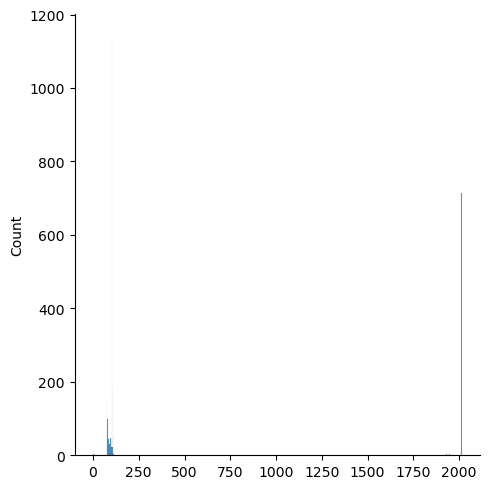

In [84]:
sns.displot(outliers_age)

## Columns selection

# 3.0 Data Preparation

In [52]:
#split dataset training/validation
X = df2.drop(columns='country_destination')
y = df2['country_destination'].copy()

In [53]:
X.drop(columns='id',axis=1, inplace=True)

aux= pd.get_dummies(X)

X = pd.concat([df2['id'],aux],axis=1)

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=32)

# 4.0 Feature Selection

In [55]:
cols_drop = ['id','date_account_created', 'timestamp_first_active', 'date_first_booking']
X_train = X_train.drop(cols_drop, axis=1)
X_val = X_val.drop(cols_drop, axis=1)

# 5.0 ML Modeling

### Baseline Model

In [56]:
df2['country_destination'].value_counts(normalize=True).sort_index().to_list()

[0.002541155140655589,
 0.006707299431977086,
 0.005019625239890832,
 0.010670922820248233,
 0.02362261676294446,
 0.011066320773822727,
 0.013457996200322104,
 0.5796726876452605,
 0.003621266623590792,
 0.001031892220304167,
 0.2944605711089466,
 0.048127646032036876]

In [57]:
#build a random model - baseline

#values to pick ramdomly
country_dest_list = sorted(df2['country_destination'].unique())

#classes presence
target_weights = df2['country_destination'].value_counts(normalize=True).sort_index().to_list()

#size 
k_num = y_val.shape[0]

yhat_baseline = random.choices(population=country_dest_list, weights=target_weights, k=k_num)

Accuracy 0.4252856936207146
 Balanced Accuracy 0.08255912913131801
 Kappa score -0.0008837768178038274
              precision    recall  f1-score   support

          AU       0.01      0.01      0.01       111
          CA       0.01      0.01      0.01       281
          DE       0.00      0.00      0.00       215
          ES       0.01      0.01      0.01       428
          FR       0.03      0.03      0.03      1021
          GB       0.00      0.00      0.00       426
          IT       0.02      0.02      0.02       570
         NDF       0.58      0.58      0.58     23996
          NL       0.00      0.00      0.00       146
          PT       0.00      0.00      0.00        48
          US       0.30      0.29      0.29     12280
       other       0.04      0.04      0.04      1956

    accuracy                           0.43     41478
   macro avg       0.08      0.08      0.08     41478
weighted avg       0.43      0.43      0.43     41478



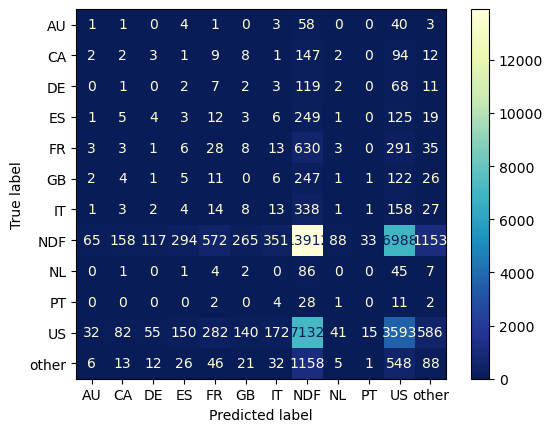

In [58]:
#acuracy
acc_base = accuracy_score(y_val, yhat_baseline)
print('Accuracy {}'.format(acc_base))

#balanced accuracy
balanced_acc_base = balanced_accuracy_score(y_val, yhat_baseline)
print(' Balanced Accuracy {}'.format(balanced_acc_base))

#Kappa score - estimators agreement
kappa_base = cohen_kappa_score(y_val, yhat_baseline)
print(' Kappa score {}'.format(kappa_base))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, yhat_baseline, cmap='YlGnBu_r');

#classification report
print(classification_report(y_val, yhat_baseline))

### 5.2 Neural Network MLP 

In [61]:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [62]:
#model definition
model = ml.Sequential()

#1st layer
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))

#output layer
model.add(l.Dense(11, activation='softmax'))
          
#model compile
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
          
#train model
model.fit(X_train,y_train_nn, epochs=100)

# #prediction
# pred_nn = model.predict(X_val)

# #invert prediction
# yhat_nn = ohe.inverse_transform(pred_nn) 

# #prediction prepare
# y_val_nn = y_val.to_numpy()
# yhat_nn = yhat_nn.reshape(1,-1)[0]

Epoch 1/100


ValueError: in user code:

    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\marco\Anaconda3\envs\airbnb-predict-1st-booking\lib\site-packages\keras\backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 12) and (None, 11) are incompatible


### 5.2.1 NN Performance

In [ ]:
#acuracy
acc_nn = accuracy_score(y_val_nn, yhat_nn)
print('Accuracy {}'.format(acc_nn))

#balanced accuracy
balanced_acc_nn = balanced_accuracy_score(y_val_nn, yhat_nn)
print(' Balanced Accuracy {}'.format(balanced_acc_nn))

#Kappa score - estimators agreement
kappa = cohen_kappa_score(y_val_nn, yhat_nn)
print(' Kappa score {}'.format(kappa))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val_nn, yhat_nn, cmap='YlGnBu_r');

#classification report
print(classification_report(y_val_nn, yhat_nn))

### 5.2.1 NN Performance - Cross validation

In [ ]:
#generate k-fold
n_folds=5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True,random_state=32)
balanced_acc_list = []
kappa_list = []
i=1

for train_ix, val_ix in kfold.split(X_train, y_train):

    print('Fold {}/{}'.format(i,n_folds))
    
    #define fold
    X_train_cv = X_train.iloc[train_ix]
    y_train_cv = y_train.iloc[train_ix]

    X_val_cv = X_train.iloc[val_ix]
    y_val_cv = y_train.iloc[val_ix]


    #target one-hot encoding
    ohe = OneHotEncoder()
    y_train_cv_nn = ohe.fit_transform(y_train_cv.values.reshape(-1,1)).toarray()
    
    
    #model definition
    model = ml.Sequential()
    model.add(l.Dense( 128, input_dim=X_train_cv.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax' ))

    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #training model
    model.fit(X_train_cv, y_train_cv_nn, epochs=100, batch_size=32, verbose=0)

    #prediction
    pred_nn_cv = model.predict(X_val_cv)
    yhat_nn_cv = ohe.inverse_transform(pred_nn_cv)
    
    y_val_nn_cv = y_val_cv.to_numpy()
    yhat_nn_cv = yhat_nn_cv.reshape(1,-1)[0]
    
    #balanced accuracy
    balanced_acc_nn = balanced_accuracy_score(y_val_nn_cv, yhat_nn_cv)
    balanced_acc_list.append(balanced_acc_nn)
    
    #Kappa score - estimators agreement
    kappa = cohen_kappa_score(y_val_nn_cv, yhat_nn_cv)
    kappa_list.append(kappa)
    
    i+=1


In [ ]:
print('Balanced Accuracy after {} K-Folds CV is {} ± {}'.format(n_folds, np.round(np.mean(balanced_acc_list),2), 
                                                                         np.round(np.std(balanced_acc_list),4)))
print('Kappa Score after {} K-Folds CV is {} ± {}'.format(n_folds, np.round(np.mean(kappa_list),4), 
                                                                         np.round(np.std(kappa_list),4)))